# Use Python <3.10

This package heavily utilizes the pyMuellerMat package that makes Mueller matrices from "system dictionaries" detailing the instrument configuration. Make sure to clone the physical_models branch of pyMuellerMat at https://github.com/maxwellmb/pyMuellerMat/.

In [1]:
import sys
import numpy as np
from pathlib import Path
from vampires_calibration.instruments import fit_CHARIS_Mueller_matrix_by_bin_pickoff
from vampires_calibration.csv_tools import write_fits_info_to_csv,read_csv,read_csv_physical_model_all_bins
from vampires_calibration.fitting import *
from vampires_calibration.utils import *
from vampires_calibration.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib as plt
# Plot settings that I like
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})

# Step 1: Write FITS Info to CSV

In [9]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_3/cubes/no_pick'
raw_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_3/internal-cal/no_pick'

# Write all bins to csvs
for bin in range(0,22):
   csv_filepath = f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'
   #write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin0_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin1_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin2_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin3_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin5_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin6_no_pickoff.csv
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/D

# Step 2 (Optional): Plot Your Data With the Original Model 

In [20]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# I have bin 15 here, I would recommend using a bin in the middle to get a good idea of goodness of
# fit, bin zero and lower bins can be finicky
filepath = Path('datacsvs/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv')
# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath,mode='wavelength')
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  128
[ 39404345.64793116  40591442.17880338 -41916458.5594697
  43621253.76586676  30686355.6422528   40830004.24532521
 -33046151.66666281  43525271.70370424   3142377.12821031
  41640928.8214519 ]
Interleaved Stds
Length:  128
[6371.14135605 6371.14135605 6604.63880662 6604.63880662 6389.83601083
 6389.83601083 6597.36854387 6597.36854387 6452.97829079 6452.97829079]
Configuration List
Length:  64
[{'hwp': {'theta': 0.0, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 45.0, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 11.25, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 56.25, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 22.5, 'wavelength': 1328.6331}, 'image_rotator': {'theta': 45.0, 'wavelength': 1328.6331}}, {'hwp': {'theta': 

In [21]:

# Define wavelength bins for CHARIS
wavelength_bin = 2
wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Loading in past fits 

offset_imr = 0.13214 # derotator offset
offset_hwp = -0.99287 # HWP offset
offset_cal = 0.49797 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# using MCMC results for physical model as a starting point
system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
                "pickoff" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": 0, "delta_theta":0 },
                    "tag": "internal",
                },      
                "image_rotator" : {
                    "type" : "SCExAO_IMR_function",
                    "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": 264.8, "theta": imr_theta, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "two_layer_HWP_function",
                    "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2":1.72, "w_MgF2": 1.34, "theta":hwp_theta, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[0.49889574 0.49882038 0.00867158 0.        ]
 [0.49889574 0.49882038 0.00867158 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [22]:
from vampires_calibration.utils import process_dataset
import matplotlib.pyplot as plt
interleaved_vals, errs, configs = read_csv_physical_model_all_bins('datacsvs/csvs_nopickoff')
inter_2, errs2,configs2 = read_csv_physical_model_all_bins('datacsvs/csvs_pickoff')
# interleaved_vals = process_dataset(interleaved_vals)
# inter_2 = process_dataset(inter_2)
diffsnopick = interleaved_vals[::2]
diffspick = inter_2[::2]


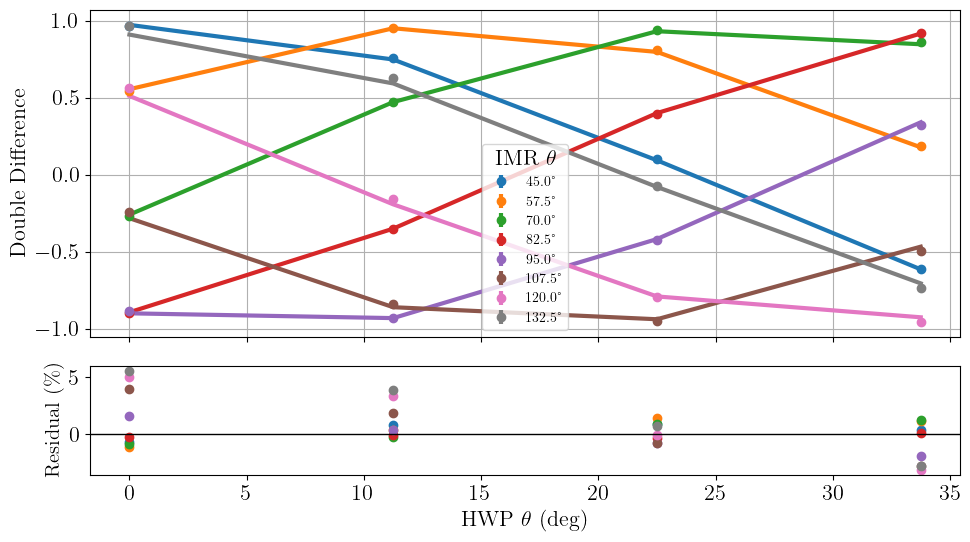

In [23]:

# Get our model retardances from Joost t Hart physical models

p = [0, 0]


# Define what is in the p list

system_parameters = [['pickoff', 'phi'], ['pickoff', 'delta_theta']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities)

# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[4],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1931.png',bbox_inches='tight', dpi=600)




# Step 3: Fit for Retardances

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0668e+08                                    6.81e+07    
       1              2         8.7472e+07      1.92e+07       3.41e+00       1.97e+07    
       2              3         8.3128e+07      4.34e+06       1.74e+00       6.54e+06    
       3              4         8.3120e+07      8.23e+03       1.51e+00       5.69e+07    
       4              5         8.1211e+07      1.91e+06       3.30e-01       3.00e+06    
       5              6         8.0660e+07      5.52e+05       1.94e-01       2.08e+06    
       6              7         8.0177e+07      4.82e+05       5.66e-01       1.20e+07    
       7              8         7.9423e+07      7.54e+05       9.79e-01       5.40e+06    
       8              9         7.9137e+07      2.86e+05       5.23e-01       4.33e+06    
       9             10         7.9079e+07      5.78e+04       1.08e-01       6.28e+04    

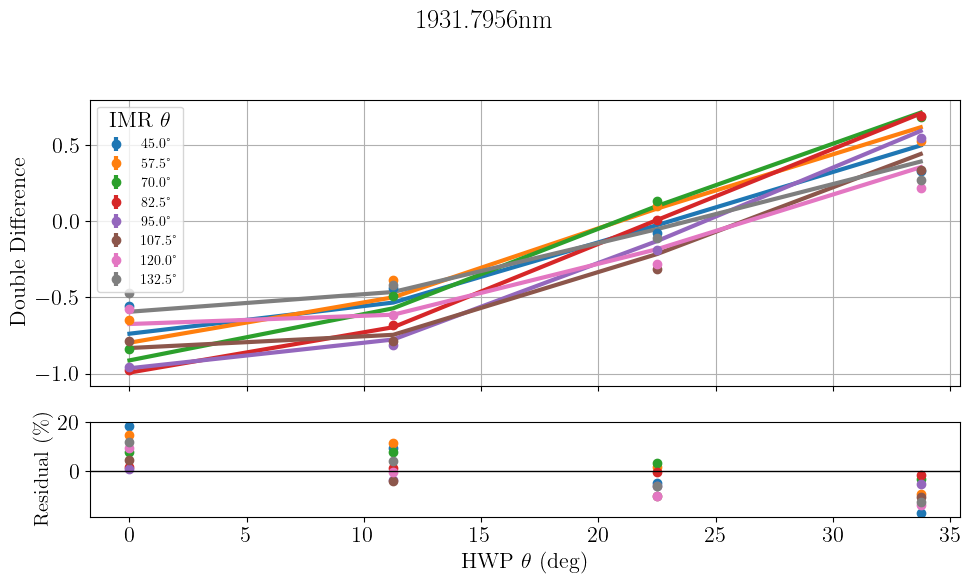

Updated Mueller Matrix:
[[ 0.13809611  0.13808069 -0.00206352  0.        ]
 [-0.13809611 -0.13808069  0.00206352  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.16623303300121284 0.18444886188496867
Error: [ 1.11104735  1.12566599 19.18027318]


/var/folders/2v/qmxm7kj51fg6kf7g36xrbysr0000gn/T/ipykernel_18970/2079102285.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [6]:
# Test fitting with the wavelength bin we plotted earlier

error, fig2, ax2 = fit_CHARIS_Mueller_matrix_by_bin_pickoff(filepath, 15, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dicts_with_pickoff/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1329.png',bbox_inches='tight', dpi=600)



Looks like our model improved! Note that the Joost't Hart paper used a more elaborate physical model, which I will incorporate later. These fits are a good starting point for more detailed models. Now we can fit for all bins and collect the errors.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2584e+06                                    3.62e+06    
       1              2         2.6306e+06      6.28e+05       1.79e+00       6.13e+05    
       2              3         2.5739e+06      5.68e+04       6.15e-01       5.03e+04    
       3              4         2.5698e+06      4.02e+03       6.27e-01       3.66e+05    
       4              5         2.5655e+06      4.33e+03       6.77e-01       3.59e+03    
       5              7         2.5645e+06      9.70e+02       5.22e-01       1.42e+05    
       6              8         2.5633e+06      1.22e+03       7.97e-01       1.59e+05    
       7              9         2.5628e+06      5.72e+02       3.90e-01       1.54e+04    
       8             10         2.5624e+06      3.47e+02       3.60e-01       4.52e+04    
       9             11         2.5624e+06      3.30e+01       2.80e-02       9.25e+01    

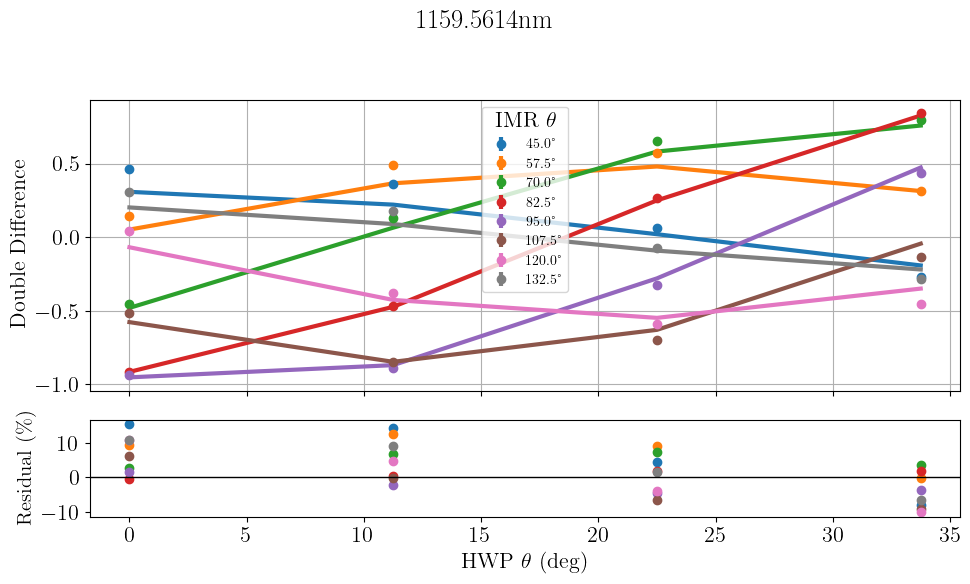

Updated Mueller Matrix:
[[ 0.3260634   0.326027   -0.00487224  0.        ]
 [-0.3260634  -0.326027    0.00487224  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.10143857247324595 0.15369766469642399
Error: [  3.41803813   0.69456486 207.1863919 ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8005e+06                                    1.70e+06    
       1              2         2.5558e+06      2.45e+05       8.27e-01       1.05e+05    
       2              4         2.5404e+06      1.55e+04       3.35e-01       7.91e+04    
       3              5         2.5336e+06      6.74e+03       4.43e-01       2.11e+05    
       4              6         2.5249e+06      8.73e+03       7.21e-01       3.28e+05    
       5              7         2.5221e+06      2.80e+03       2.16e-01       3.32e+03    
       6             

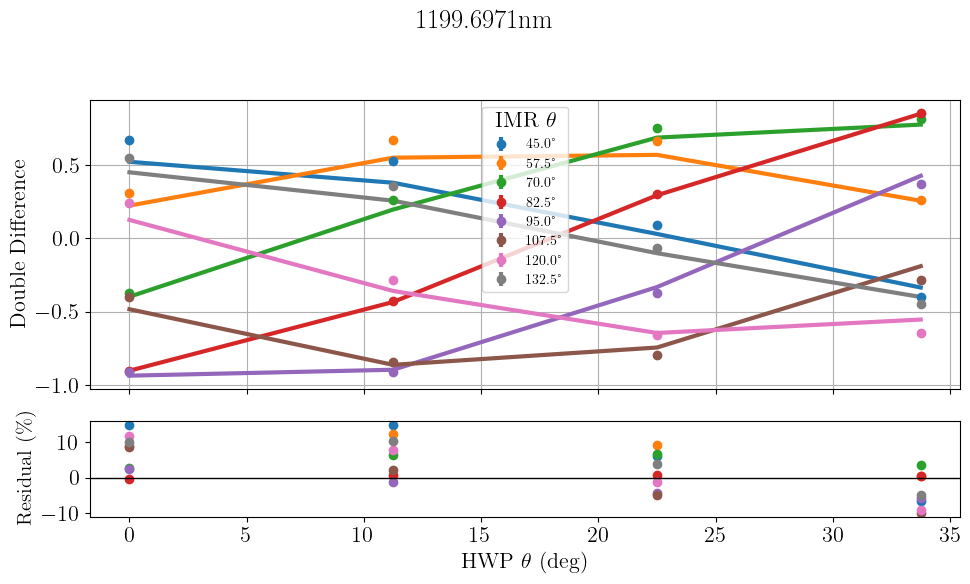

Updated Mueller Matrix:
[[ 0.37086057  0.37081916 -0.00554162  0.        ]
 [-0.37086057 -0.37081916  0.00554162  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.09755503380534261 0.14818223503232147
Error: [ 1.32641472  0.65385823 31.42111809]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2160e+06                                    9.08e+05    
       1              2         1.0342e+06      1.82e+05       2.39e-01       1.34e+05    
       2              3         1.0142e+06      2.01e+04       9.14e-01       7.75e+05    
       3              4         1.0101e+06      4.05e+03       8.94e-02       3.83e+04    
       4              5         1.0081e+06      2.04e+03       5.22e-02       1.43e+05    
       5              6         1.0079e+06      2.29e+02       1.04e-02       7.08e+03    
       6              7 

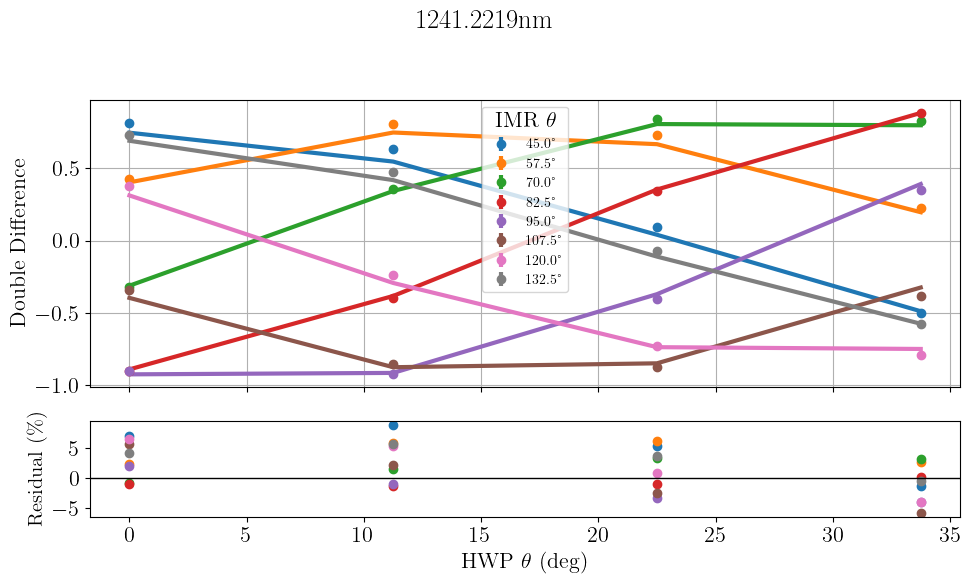

Updated Mueller Matrix:
[[ 0.41136473  0.4113188  -0.00614686  0.        ]
 [-0.41136473 -0.4113188   0.00614686  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.057110467079198146 0.08753262279174479
Error: [0.54741228 0.38747891 9.71827834]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0907e+06                                    9.17e+05    
       1              2         8.5600e+05      2.35e+05       3.46e-01       5.41e+05    
       2              3         8.3990e+05      1.61e+04       8.39e-01       1.25e+05    
       3              4         8.2975e+05      1.02e+04       2.72e-01       1.23e+06    
       4              6         8.2363e+05      6.12e+03       8.13e-02       6.45e+04    
       5              7         8.2224e+05      1.39e+03       5.87e-03       5.14e+04    
       6              8   

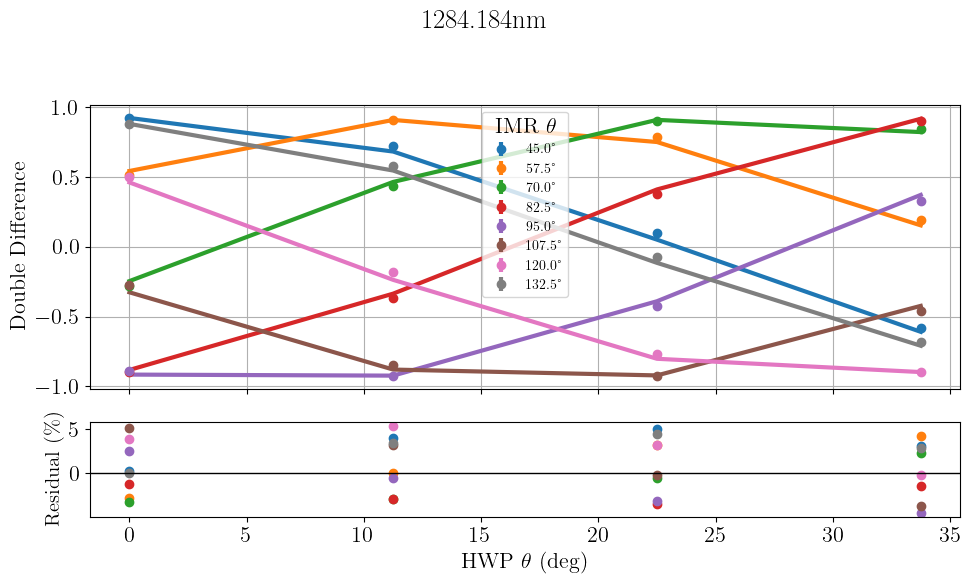

Updated Mueller Matrix:
[[ 0.43893525  0.43888624 -0.00655884  0.        ]
 [-0.43893525 -0.43888624  0.00655884  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04499374245991572 0.053273097727989216
Error: [0.41297698 0.4519869  7.33397698]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9945e+06                                    1.91e+06    
       1              2         1.2314e+06      7.63e+05       3.90e+00       1.79e+05    
       2              4         1.2129e+06      1.85e+04       8.29e-01       5.81e+05    
       3              5         8.3251e+05      3.80e+05       6.49e-01       1.92e+06    
       4              6         2.2260e+05      6.10e+05       1.32e+00       3.57e+06    
       5              7         9.1855e+04      1.31e+05       3.72e-01       4.22e+05    
       6              8   

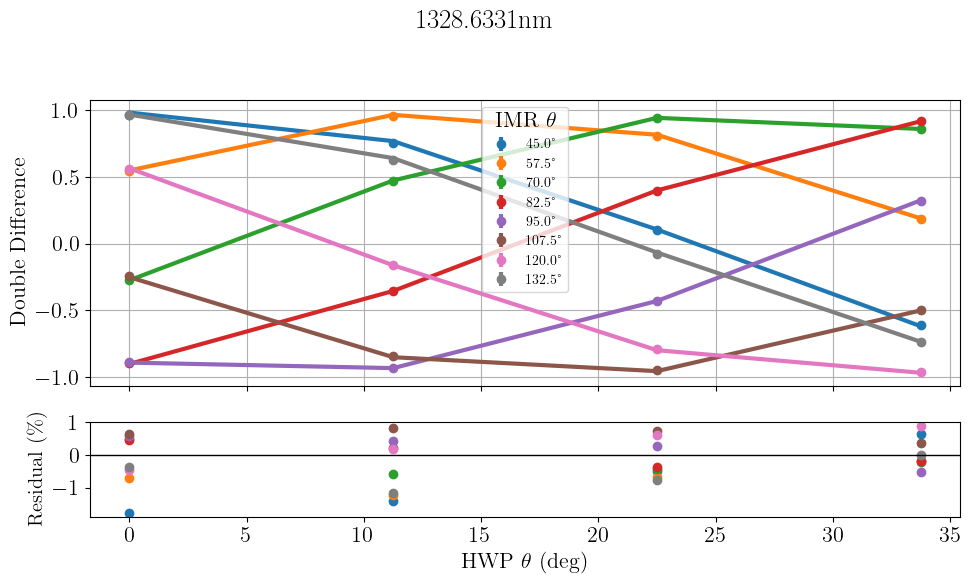

Updated Mueller Matrix:
[[ 0.19080834  0.19078704 -0.00285117  0.        ]
 [-0.19080834 -0.19078704  0.00285117  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.01767600076819753 0.008890921074553249
Error: [0.12560041 0.03304611 0.82003089]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3711e+07                                    2.09e+07    
       1              2         6.9111e+06      6.80e+06       3.15e+00       4.32e+06    
       2              3         5.8178e+06      1.09e+06       3.32e+00       1.38e+07    
       3              5         3.3125e+06      2.51e+06       4.52e-01       1.19e+07    
       4              6         2.5274e+06      7.85e+05       5.19e-01       1.73e+06    
       5              7         2.3616e+06      1.66e+05       8.86e-01       1.64e+06    
       6              8   

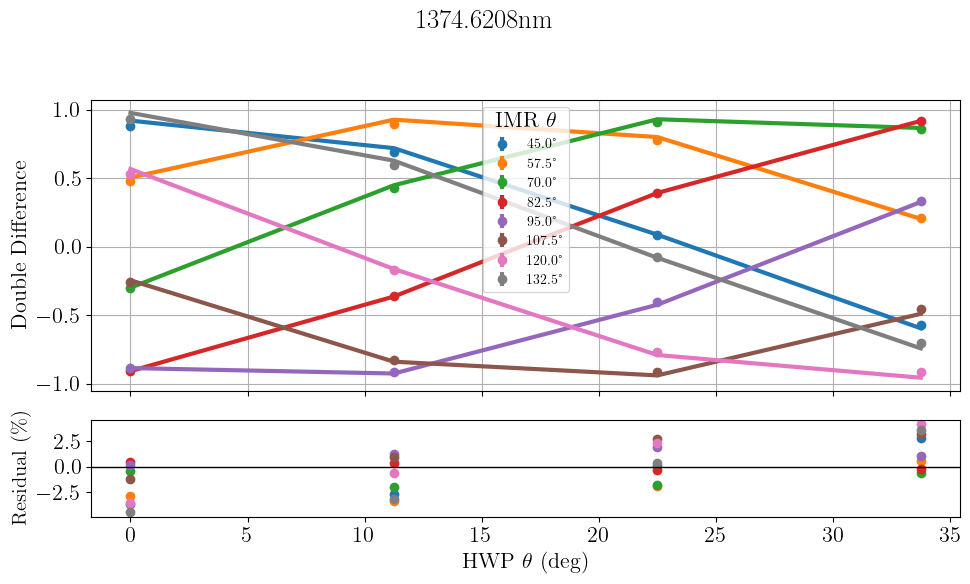

Updated Mueller Matrix:
[[ 0.24853861  0.24851087 -0.00371381  0.        ]
 [-0.24853861 -0.24851087  0.00371381  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.044783136444194516 0.0412357494766713
Error: [0.29528641 0.08164448 3.25848078]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.1494e+06                                    1.84e+07    
       1              2         3.2641e+06      4.89e+06       2.66e+00       3.98e+06    
       2              3         2.3537e+06      9.10e+05       2.22e+00       3.03e+06    
       3              4         2.1740e+06      1.80e+05       1.53e+00       1.38e+07    
       4              5         1.2968e+06      8.77e+05       5.38e-01       1.92e+06    
       5              6         1.2431e+06      5.36e+04       2.08e-01       1.36e+05    
       6              8    

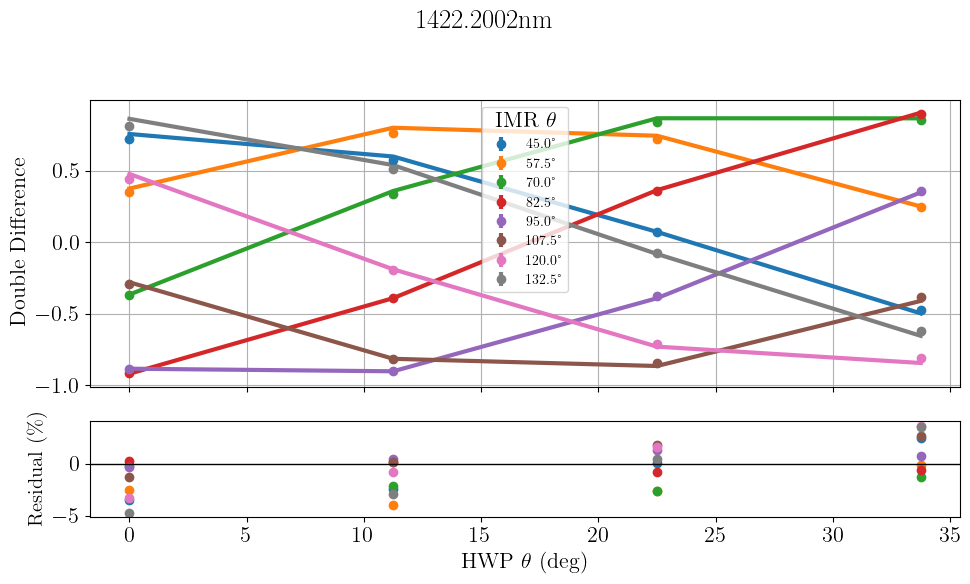

Updated Mueller Matrix:
[[ 0.23752035  0.23749383 -0.00354917  0.        ]
 [-0.23752035 -0.23749383  0.00354917  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.047070823310929155 0.036942706582848595
Error: [0.18799443 0.07919993 3.14884328]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7884e+06                                    2.47e+07    
       1              2         2.0368e+06      5.75e+06       2.44e+00       5.34e+06    
       2              3         1.0603e+06      9.76e+05       1.70e+00       1.18e+06    
       3              5         8.0479e+05      2.56e+05       4.71e-01       1.53e+06    
       4              6         5.3903e+05      2.66e+05       7.66e-01       1.82e+06    
       5              7         5.0039e+05      3.86e+04       1.10e-01       5.18e+04    
       6              9  

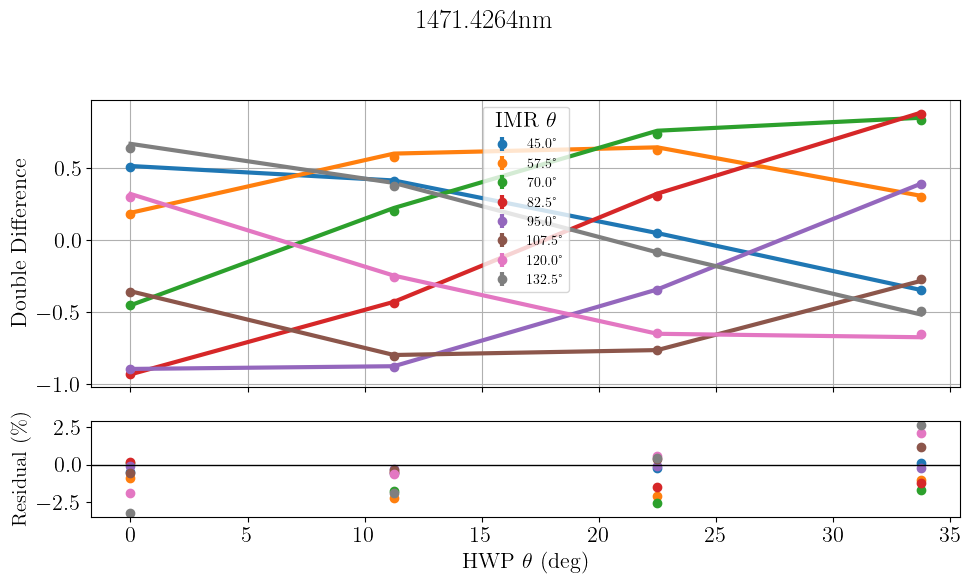

Updated Mueller Matrix:
[[ 0.25313916  0.2531109  -0.00378256  0.        ]
 [-0.25313916 -0.2531109   0.00378256  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.031875772792463675 0.026115859975931133
Error: [0.09488057 0.05128193 2.79090586]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.2704e+06                                    2.69e+07    
       1              2         1.4547e+06      5.82e+06       2.35e+00       5.82e+06    
       2              3         5.3765e+05      9.17e+05       1.49e+00       1.28e+06    
       3              4         3.7380e+05      1.64e+05       1.11e+00       9.54e+05    
       4              5         3.4790e+05      2.59e+04       3.67e-01       5.50e+04    
       5              7         3.4648e+05      1.42e+03       1.15e-01       2.03e+04    
       6              8  

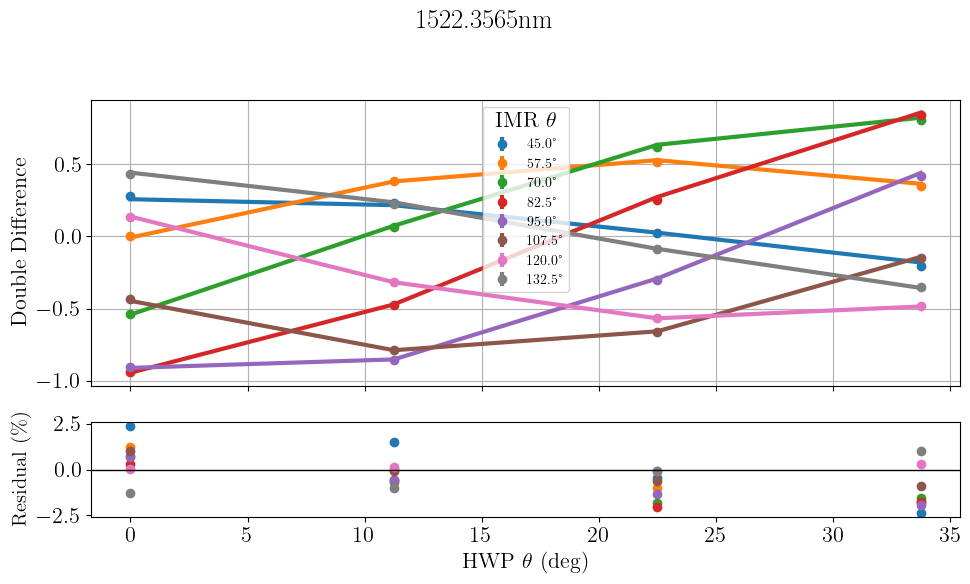

Updated Mueller Matrix:
[[ 0.26907918  0.26904913 -0.00402074  0.        ]
 [-0.26907918 -0.26904913  0.00402074  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.023462567215405156 0.02380588065456596
Error: [0.09458684 0.04847108 6.08105895]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1877e+07                                    3.57e+07    
       1              2         4.1284e+06      7.75e+06       2.42e+00       7.86e+06    
       2              3         2.8771e+06      1.25e+06       1.53e+00       1.77e+06    
       3              4         2.6968e+06      1.80e+05       9.06e-01       6.97e+05    
       4              5         2.6816e+06      1.52e+04       5.73e-01       7.42e+05    
       5              6         2.6746e+06      6.96e+03       5.78e-01       5.60e+05    
       6              7   

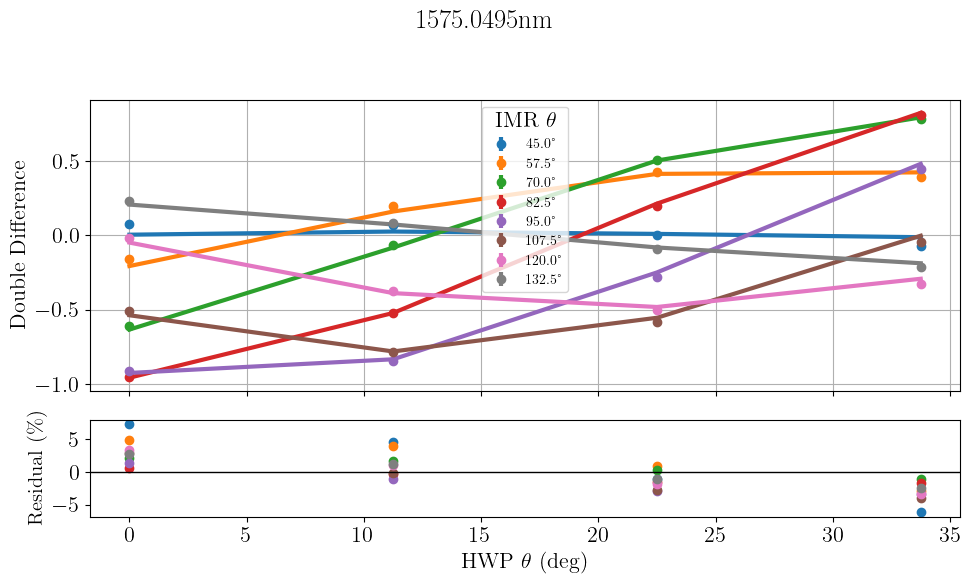

Updated Mueller Matrix:
[[ 0.26765946  0.26762958 -0.00399953  0.        ]
 [-0.26765946 -0.26762958  0.00399953  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.062178479721650984 0.073140151918061
Error: [  1.79127899   0.20499738 139.464351  ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9718e+07                                    4.69e+07    
       1              2         9.8685e+06      9.85e+06       2.34e+00       1.04e+07    
       2              3         7.5271e+06      2.34e+06       1.62e+00       3.29e+06    
       3              4         6.9355e+06      5.92e+05       1.18e+00       1.71e+06    
       4              5         6.9020e+06      3.35e+04       1.01e+00       5.06e+06    
       5              6         6.8317e+06      7.02e+04       4.09e-01       8.00e+04    
       6              

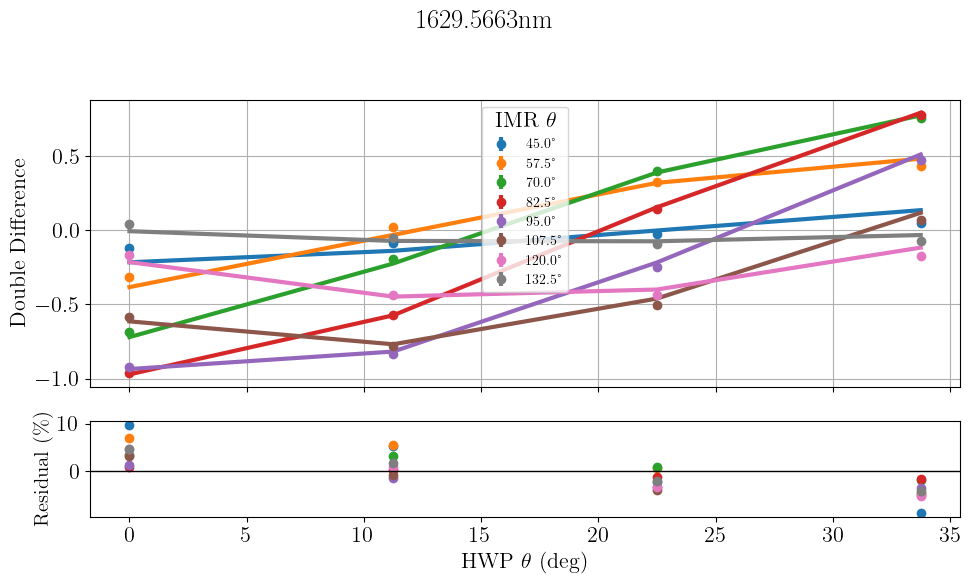

Updated Mueller Matrix:
[[ 0.22887583  0.22885028 -0.00342     0.        ]
 [-0.22887583 -0.22885028  0.00342     0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.08846467887018225 0.09664986216188744
Error: [ 1.65797587  0.29448777 86.23904749]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2844e+07                                    4.13e+07    
       1              2         1.3615e+07      9.23e+06       2.51e+00       9.64e+06    
       2              3         1.1816e+07      1.80e+06       1.46e+00       3.54e+06    
       3              4         1.0888e+07      9.28e+05       1.33e+00       2.19e+06    
       4              5         1.0829e+07      5.97e+04       1.26e+00       8.80e+06    
       5              6         1.0677e+07      1.52e+05       3.89e-01       1.90e+05    
       6              8 

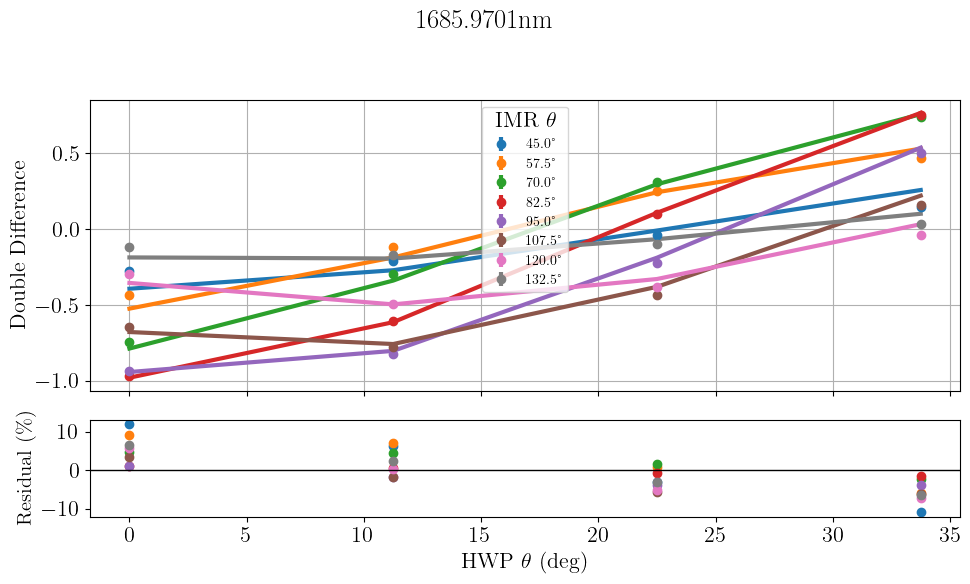

Updated Mueller Matrix:
[[ 0.1976846   0.19766253 -0.00295392  0.        ]
 [-0.1976846  -0.19766253  0.00295392  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.11006197568409787 0.1196624852237278
Error: [ 1.53563845  0.39558057 58.29564573]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1987e+07                                    4.11e+07    
       1              2         2.1987e+07      1.00e+07       2.78e+00       1.03e+07    
       2              3         2.0223e+07      1.76e+06       1.44e+00       2.67e+06    
       3              5         1.9704e+07      5.19e+05       4.46e-01       3.45e+06    
       4              6         1.8987e+07      7.17e+05       8.95e-01       1.40e+06    
       5              8         1.8852e+07      1.35e+05       4.27e-01       1.70e+06    
       6              9  

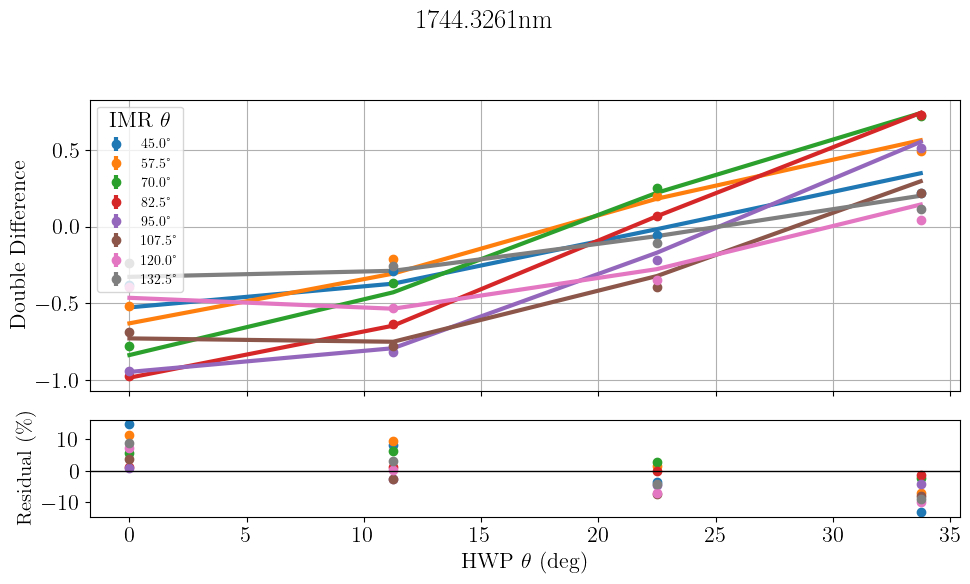

Updated Mueller Matrix:
[[ 0.17503404  0.1750145  -0.00261546  0.        ]
 [-0.17503404 -0.1750145   0.00261546  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.1320925996572241 0.14855325638433609
Error: [ 1.38071498  0.53935438 37.57860212]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0284e+07                                    6.93e+07    
       1              2         5.1853e+07      1.84e+07       3.09e+00       1.88e+07    
       2              3         4.8074e+07      3.78e+06       1.82e+00       1.22e+07    
       3              4         4.7340e+07      7.33e+05       1.19e+00       7.14e+06    
       4              5         4.5760e+07      1.58e+06       6.17e-01       1.23e+07    
       5              6         4.5071e+07      6.89e+05       1.00e+00       5.77e+05    
       6              7  

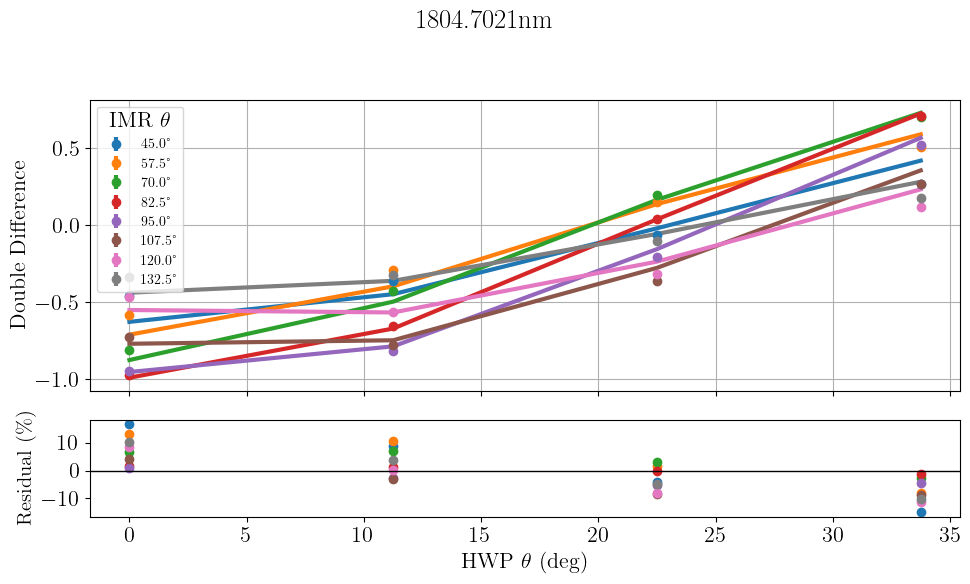

Updated Mueller Matrix:
[[ 0.15829997  0.1582823  -0.00236541  0.        ]
 [-0.15829997 -0.1582823   0.00236541  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.15093931644942943 0.16673087964977795
Error: [ 1.15838904  0.6865286  23.3880658 ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3146e+08                                    1.93e+08    
       1              2         1.7735e+08      5.41e+07       3.32e+00       5.51e+07    
       2              3         1.6501e+08      1.23e+07       1.89e+00       3.12e+07    
       3              4         1.5980e+08      5.21e+06       1.27e+00       6.80e+06    
       4              6         1.5811e+08      1.69e+06       4.32e-01       2.01e+07    
       5              7         1.5627e+08      1.83e+06       9.38e-01       2.72e+07    
       6              8 

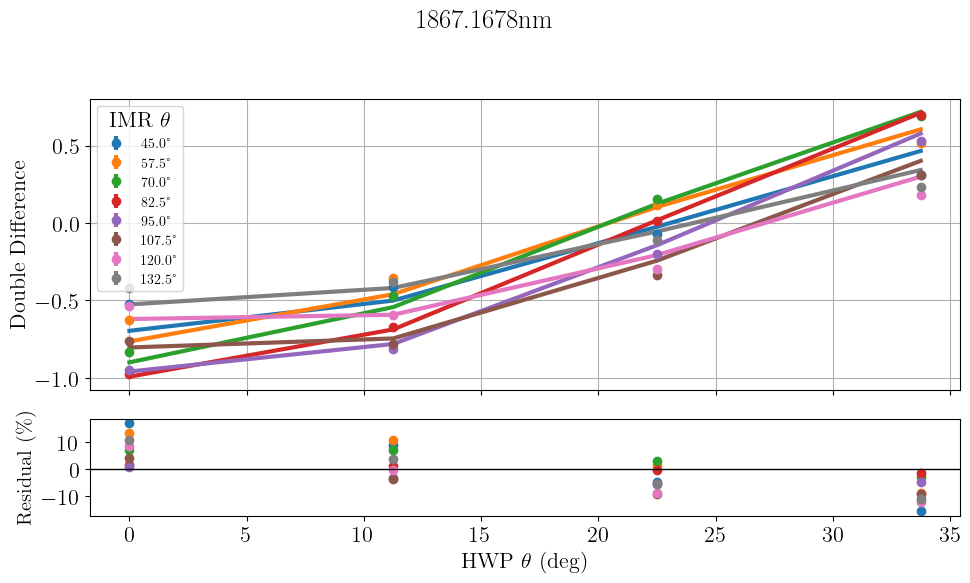

Updated Mueller Matrix:
[[ 0.14632899  0.14631265 -0.00218654  0.        ]
 [-0.14632899 -0.14631265  0.00218654  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.15658668727685526 0.17119710397148413
Error: [ 1.03151784  0.83490973 17.93445416]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0601e+08                                    7.10e+07    
       1              2         8.5441e+07      2.06e+07       3.43e+00       2.06e+07    
       2              3         8.1156e+07      4.28e+06       1.75e+00       6.47e+06    
       3              5         7.9898e+07      1.26e+06       4.50e-01       5.06e+06    
       4              6         7.8601e+07      1.30e+06       9.09e-01       2.04e+07    
       5              7         7.7181e+07      1.42e+06       1.00e+00       1.50e+06    
       6              8 

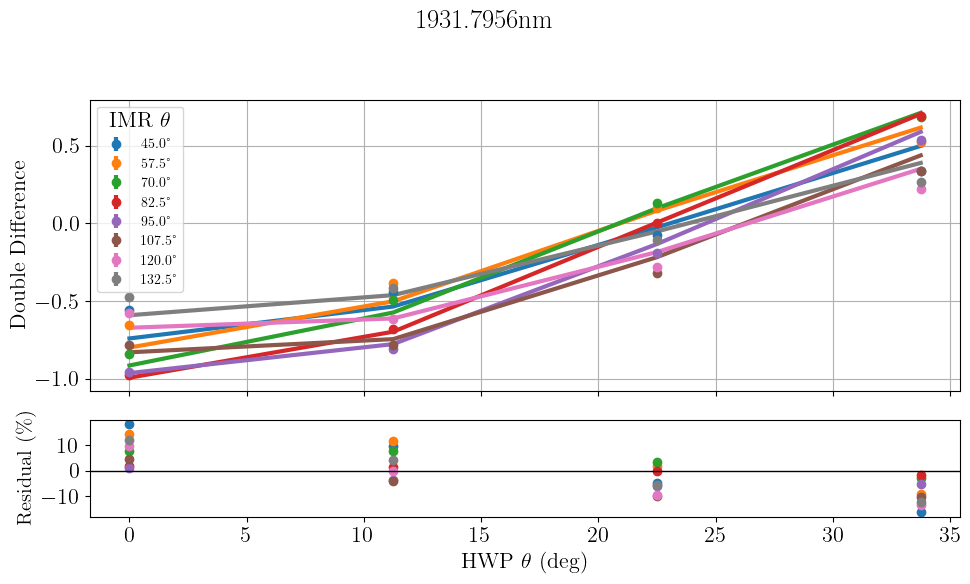

Updated Mueller Matrix:
[[ 0.13841785  0.13840239 -0.00206832  0.        ]
 [-0.13841785 -0.13840239  0.00206832  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.16318904375773757 0.18189946193390227
Error: [ 0.9936415   1.11161912 15.51104337]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.2532e+07                                    4.97e+07    
       1              2         7.7443e+07      1.51e+07       3.57e+00       1.38e+07    
       2              4         7.5854e+07      1.59e+06       7.03e-01       9.33e+06    
       3              5         7.3606e+07      2.25e+06       1.18e+00       5.50e+06    
       4              7         7.2850e+07      7.55e+05       5.14e-01       4.09e+06    
       5              8         7.1887e+07      9.63e+05       9.55e-01       1.42e+07    
       6              9 

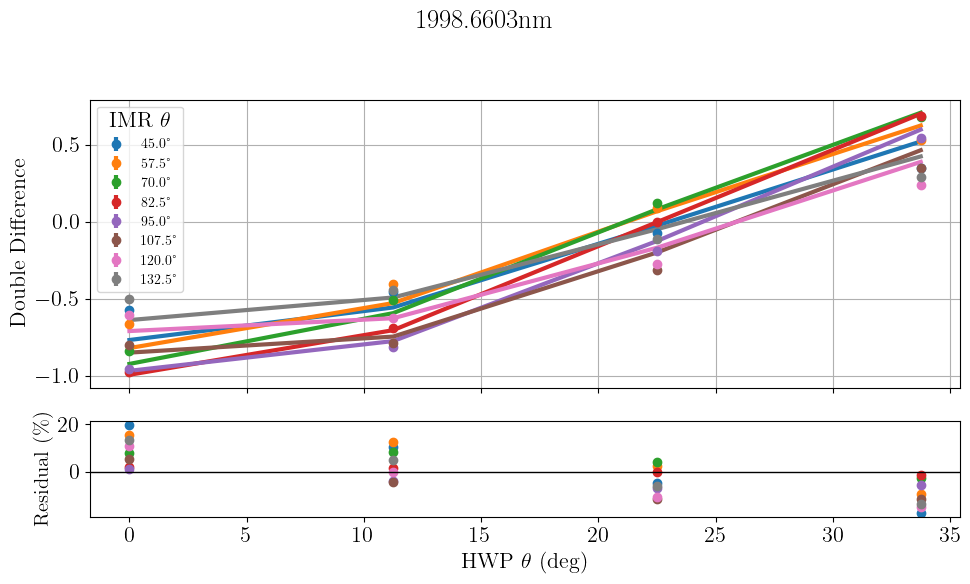

Updated Mueller Matrix:
[[ 0.13388526  0.13387031 -0.00200059  0.        ]
 [-0.13388526 -0.13387031  0.00200059  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.17148416217664847 0.19556280202844223
Error: [ 0.97418147  1.6257113  13.74636661]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.4948e+07                                    3.85e+07    
       1              2         7.2907e+07      1.20e+07       3.71e+00       9.72e+06    
       2              4         7.1925e+07      9.81e+05       8.45e-01       2.85e+06    
       3              5         7.0895e+07      1.03e+06       8.83e-01       1.37e+07    
       4              7         7.0301e+07      5.94e+05       3.27e-01       4.15e+06    
       5              8         6.9843e+07      4.58e+05       2.99e-01       3.94e+06    
       6              9 

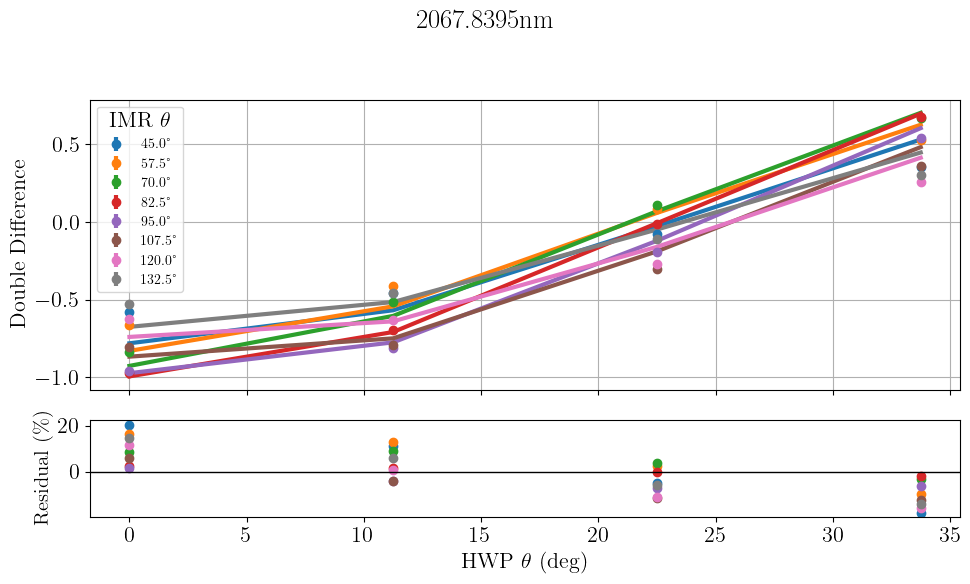

Updated Mueller Matrix:
[[ 0.13183341  0.13181869 -0.00196993  0.        ]
 [-0.13183341 -0.13181869  0.00196993  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.17798720269148033 0.20439520609346684
Error: [ 0.99229628  2.70207574 13.60510247]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0035e+07                                    2.72e+07    
       1              2         6.1483e+07      8.55e+06       3.80e+00       5.63e+06    
       2              4         6.1430e+07      5.27e+04       7.93e-01       2.98e+06    
       3              5         6.1211e+07      2.19e+05       1.11e-01       1.41e+06    
       4              6         6.0925e+07      2.86e+05       1.56e-01       2.73e+06    
       5              7         6.0264e+07      6.61e+05       5.27e-01       3.71e+06    
       6              8 

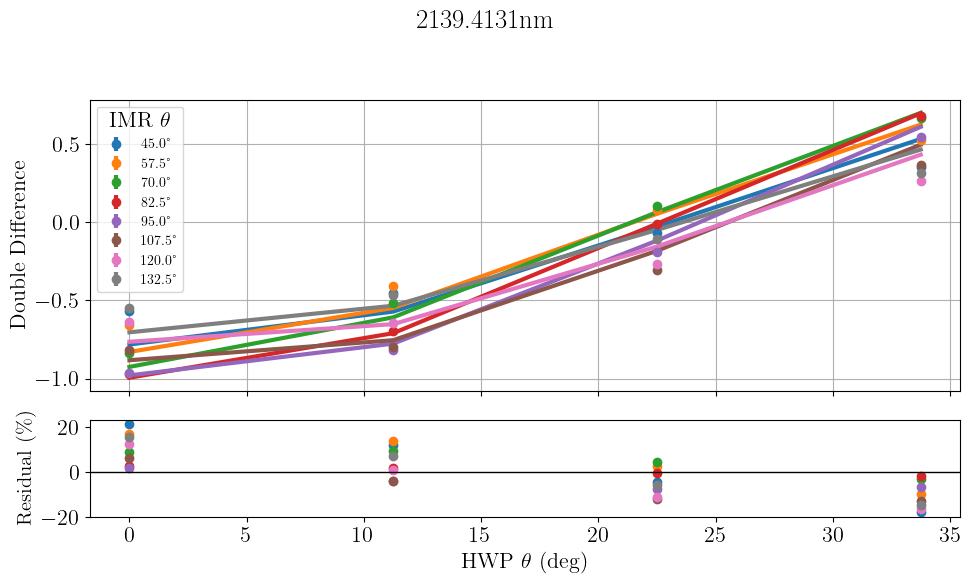

Updated Mueller Matrix:
[[ 0.13177157  0.13175686 -0.00196901  0.        ]
 [-0.13177157 -0.13175686  0.00196901  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.180629437819605 0.21225321658497764
Error: [ 1.0825058   7.59852767 15.55655507]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.3608e+07                                    2.02e+07    
       1              2         5.7401e+07      6.21e+06       3.82e+00       4.64e+06    
       2              5         5.7228e+07      1.73e+05       2.11e-01       3.62e+06    
       3              6         5.6957e+07      2.70e+05       4.17e-01       2.48e+06    
       4              7         5.6459e+07      4.99e+05       5.64e-01       2.87e+06    
       5              8         5.6157e+07      3.01e+05       1.30e+00       1.47e+07    
       6              9   

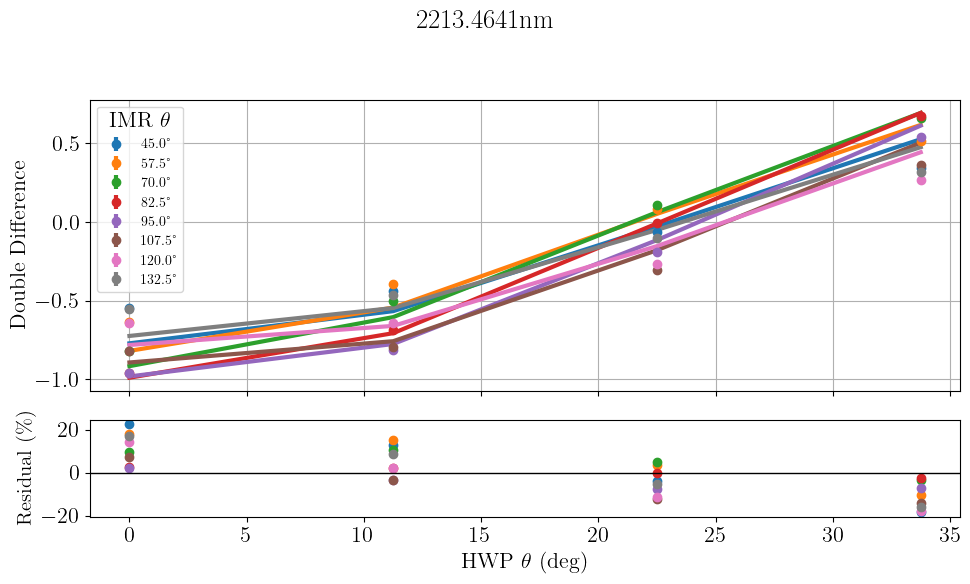

Updated Mueller Matrix:
[[ 0.13184801  0.13183329 -0.00197015  0.        ]
 [-0.13184801 -0.13183329  0.00197015  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.18462739834233305 0.22543568854598095
Error: [ 0.99785172  9.19131323 20.12361279]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8153e+07                                    1.31e+07    
       1              2         4.4325e+07      3.83e+06       3.85e+00       1.56e+06    
       2              5         4.4272e+07      5.23e+04       1.80e-01       3.50e+05    
       3              6         4.4247e+07      2.52e+04       1.24e-01       1.72e+05    
       4              7         4.4193e+07      5.43e+04       2.00e-01       8.22e+05    
       5              8         4.4041e+07      1.52e+05       4.38e-01       1.46e+06    
       6              9 

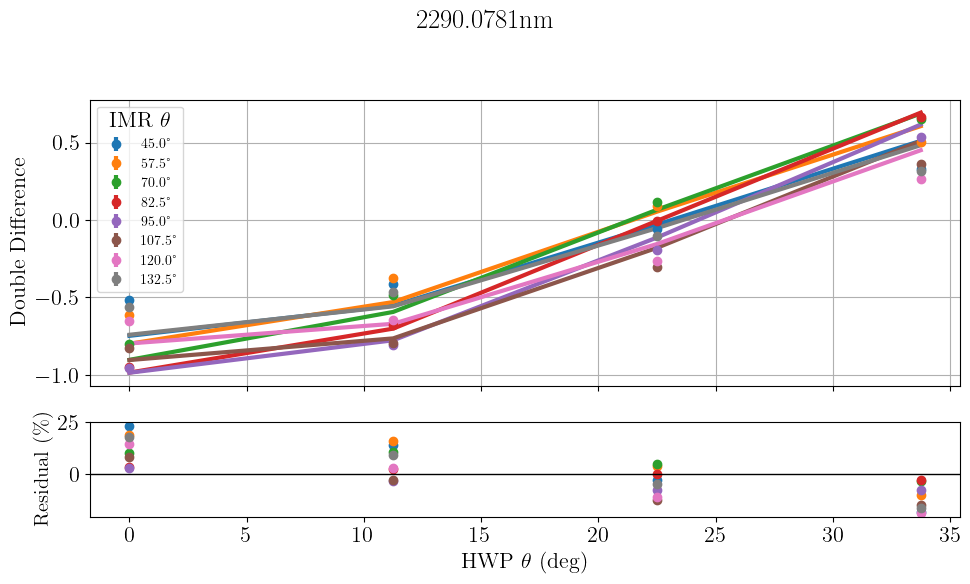

Updated Mueller Matrix:
[[ 0.1311099   0.13109526 -0.00195912  0.        ]
 [-0.1311099  -0.13109526  0.00195912  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.1859331075573601 0.2324673885693348
Error: [ 1.303691    2.79197017 30.55797944]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1138e+07                                    9.48e+06    
       1              2         3.8458e+07      2.68e+06       3.67e+00       1.53e+06    
       2              5         3.8390e+07      6.76e+04       1.85e-01       6.79e+05    
       3              6         3.8363e+07      2.69e+04       3.14e-01       2.20e+06    
       4              7         3.8207e+07      1.56e+05       4.12e-01       2.13e+06    
       5              8         3.7366e+07      8.40e+05       5.49e-01       7.53e+06    
       6              9   

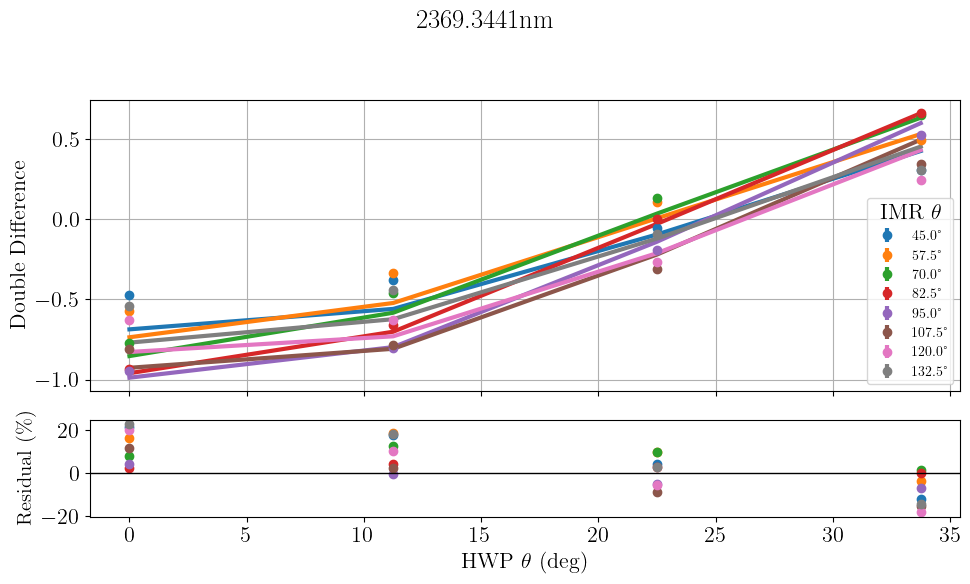

Updated Mueller Matrix:
[[ 0.13948759  0.13947202 -0.00208431  0.        ]
 [-0.13948759 -0.13947202  0.00208431  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.18385864346387604 0.22698753299540853
Error: [2.09796988 1.60014186 0.50637907]


In [7]:
# Fit all 22 wavelength bins
errors = []
for bin in range(0,22):
    error = fit_CHARIS_Mueller_matrix_by_bin_pickoff(
        Path(f'datacsvs/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv'),
        bin,
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets/sysdictbin{bin}nopick.json'),
        plot_path=Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/plots_justrets/bin{bin}nopick.png')
    )[0]
    errors.append(error)


In [4]:
# find average error
errors = np.array(errors)
print('pickoff_ret', np.mean(errors[:,0]))
print('pickoff_offset',np.mean(errors[:,1]))



    

pickoff_ret 0.8591047254114081
pickoff_offset 25.11930543197441


In [7]:
# Now let's make a dataframe of our data, this model data function can be changed easily to include
# whatever parameters you're fitting
from vampires_calibration.plotting import model_data
json_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets'
df = model_data(json_dir)
df

,wavelength_bin,pickphi,pickoffoff
0,1159.5614,0.081807,5.000000
1,1199.6971,0.194780,5.000000
2,1241.2219,0.235090,5.000000
3,1284.1840,0.216184,5.000000
4,1328.6331,0.959240,-3.395535
5,1374.6208,0.683815,-3.252282
6,1422.2002,2.588989,-0.450526
7,1471.4264,2.373945,-0.312329
8,1522.3565,1.130781,-0.268333
9,1575.0495,0.065208,-5.000000


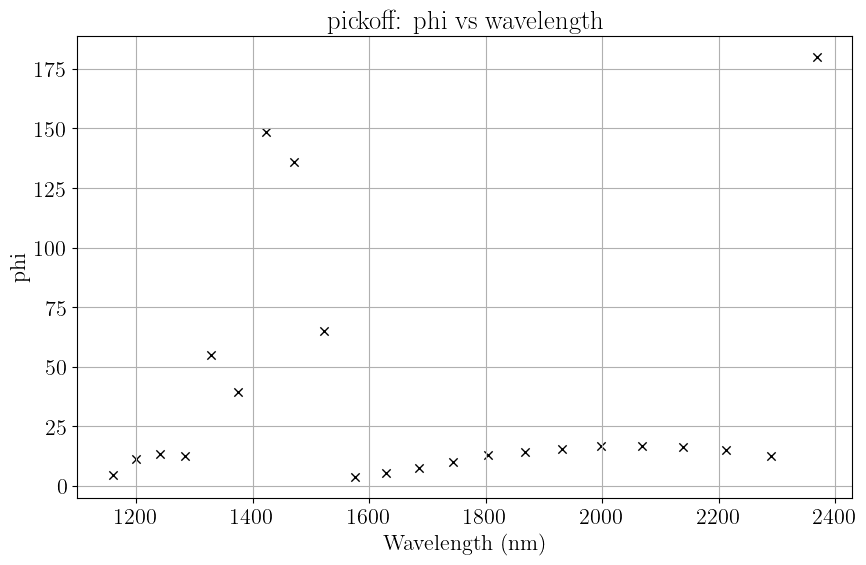

In [10]:
from vampires_calibration.plotting import plot_config_dict_vs_wavelength
params,fig_pick, ax_pick = plot_config_dict_vs_wavelength('pickoff','phi','/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/sys_dics_justrets')

# Step 4: Refine Retardance Model

This step depends heavily on what components you are fitting to. I'm going to make the IMR and HWP retardances a function of wavelength using the Joost t Hart 2021 physical models. I'll use the parameters we just fitted as my dataset. 

In [11]:
def phys_model_chisq(p0, wavelengths, retardances_hwp, errors_hwp, retardances_imr,errors_imr):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [w_sio2, w_mgf2, d].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    retardances_hwp : list or numpy array
        Retardances of the HWP at the specified wavelengths.

    errors_hwp : list or numpy array
        Errors associated with the HWP retardances.

    retardances_imr : list or numpy array
        Retardances of the IMR at the specified wavelengths.
    
    errors_imr : list or numpy array
        Errors associated with the IMR retardances.
    
    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model retardances
    model_hwp = HWP_retardance(wavelengths, p0[0], p0[1])
    model_imr = IMR_retardance(wavelengths, p0[2])
    # Calculate residuals
    residuals_hwp = (retardances_hwp - model_hwp) / errors_hwp
    residuals_imr = (retardances_imr - model_imr) / errors_imr
    # Calculate log-likelihood
    chisq_hwp = np.sum(residuals_hwp**2)
    chisq_imr = np.sum(residuals_imr**2)
    return chisq_hwp + chisq_imr

In [12]:

# Minimizing the physical model

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021
wavelengths = wavelength_bins # CHARIS wavelength bins

# Defining reasonable bounds (these values shouldn't have changed much)
  
wsio2_bounds = (0.9*p0[0], 1.1*p0[0])
wmgf2_bounds = (0.9*p0[1], 1.1*p0[1])
d_bounds = (0.9*p0[2], 1.1*p0[2])
bounds = [wsio2_bounds, wmgf2_bounds, d_bounds]

# Extract our retardances and errors from the data
errors = np.array(errors)
hwp_retardances = df['hwp_retardance'].values
imr_retardance = df['imr_retardance'].values
hwp_errors = errors[:,0] 
imr_errors = errors[:,1]  

# Use a while loop to iteratively minimize the chi squared function
# Counters for iterative fitting

iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelengths, hwp_retardances, hwp_errors, imr_retardance, imr_errors), bounds=bounds)
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)

hess_inv = result.hess_inv


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2437.668321379841
        x: [ 1.663e+00  1.298e+00  2.584e+02]
      nit: 8
      jac: [ 4.302e+00 -5.756e+00 -2.547e-03]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2437.6683213792157
        x: [ 1.663e+00  1.298e+00  2.584e+02]
      nit: 1
      jac: [ 9.732e-03  1.055e-02 -1.546e-03]
     nfev: 12
     njev: 3
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


That's It! The fit is updated. However, in the Hart 2021 paper, a degeneracy in wavelength bin 4 was noted. Because of this, I will redo the fit to see if the model fits better. 

In [13]:
# Redo the fit without the degenerate point (bin 4)

wavelengths2 = np.delete(wavelength_bins, 4)
p0_2 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021

# Defining reasonable bounds (these values shouldn't have changed much)

wsio2_bounds2 = (0.9*p0_2[0], 1.1*p0_2[0])
wmgf2_bounds2 = (0.9*p0_2[1], 1.1*p0_2[1])
d_bounds2 = (0.9*p0_2[2], 1.1*p0_2[2])
bounds2 = [wsio2_bounds2, wmgf2_bounds2, d_bounds2]

# Extract our retardances and errors from the data
errors2 = np.delete(np.array(errors), 4, axis=0)
hwp_retardances2 = df['hwp_retardance'].values
imr_retardance2 = df['imr_retardance'].values
hwp_errors2 = errors2[:,0] 
imr_errors2 = errors2[:,1]  

# Remove the corresponding retardances for the removed bin

hwp_retardances2 = np.delete(hwp_retardances2, 4)
imr_retardance2= np.delete(imr_retardance2,4)

# Use a while loop to iteratively minimize the chi squared function

# Counters for iterative fitting

iteration2 = 1
previous_logl2 = 1000000
new_logl2 = 0

while abs(previous_logl2-new_logl2)> 0.01*abs(previous_logl2):
        previous_logl2 = new_logl2
        result2 = minimize(phys_model_chisq,p0_2, args=(wavelengths2, hwp_retardances2, hwp_errors2, imr_retardance2, imr_errors2), bounds=bounds2)
        p0_2 = result2.x
        new_logl2 = result2.fun
        iteration2 += 1
        print(result2)






  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 2126.5886920305
        x: [ 1.665e+00  1.300e+00  2.584e+02]
      nit: 7
      jac: [ 1.847e+00 -2.465e+00 -3.956e-03]
     nfev: 160
     njev: 40
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 2126.5886920305
        x: [ 1.665e+00  1.300e+00  2.584e+02]
      nit: 0
      jac: [ 1.847e+00 -2.465e+00 -3.956e-03]
     nfev: 52
     njev: 13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [14]:
# Compare chi sq of all models

p0_Hart = [1.623, 1.268, 262.56]

# Hart chi sq

print("Hart:",phys_model_chisq(p0_Hart,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model with all bins

print("Our model with all bins:",phys_model_chisq(result.x,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model without bin 4

print("Our model without bin 4:",phys_model_chisq(result2.x,wavelengths2, hwp_retardances2,hwp_errors2,imr_retardance2,imr_errors2))



Hart: 8447.5197089818
Our model with all bins: 2437.6683213792157
Our model without bin 4: 2126.588692030502


In [13]:
print(1.268*1.2)

1.5216


# Step 5: Fit for Offsets Globally

In [31]:
# Get interleaved values for all wavelength bins
from vampires_calibration.constants import wavelength_bins
csvdir = Path('datacsvs/csvs_nopickoff')

interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csvdir)


wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.0018
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 258.3
wsio2 = 1.667
wmgf2 = 1.301

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "pickoff" : {
        "type" : "general_retarder_function",
        "properties" : {"phi": 0, "delta_theta":0 },
        "tag": "internal",
},      
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lprot": { # changed from delta_theta to match Joost t Hart
        "type": "rotator_function",
        "properties" : {'pa':offset_cal},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal},
        "tag": "internal",
    }}
}
    
# Starting guesses


p0_dict = {
    "image_rotator" : 
        {"d": d, "delta_theta": 0},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": 0},
    "lprot" : 
        {"pa": 0},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM

p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5,5) 
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
# Process everything into double differences and propagate errors




In [33]:
# Minimize everything globally with minimize

result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds],mode='minimize')
print(result_min)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 454264366.20675933
        x: [ 2.648e+02 -3.637e-01  1.720e+00  1.340e+00 -1.581e+00
            -3.349e-01]
      nit: 47
      jac: [ 3.664e+04 -4.134e+05  2.219e+05  5.962e+04  3.152e+05
            -3.242e+05]
     nfev: 378
     njev: 54
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [26]:
# Minimize everything globally with least squares
    # Counters for iterative fitting

iteration = 1
previous_logl = 1000000
new_logl = 0

    # Perform iterative fitting
    # MODIFY THE BOUNDS INPUT HERE IF YOU WANT TO CHANGE PARAMETERS
while abs(previous_logl - new_logl) > 0.01*abs(previous_logl):
    if iteration > 1:
        previous_logl = new_logl
    # Configuring minimization function for CHARIS
    result, new_logl, error = minimize_system_mueller_matrix(p0_dict, system_mm, interleaved_values_all, 
        interleaved_stds_all, configuration_list_all, process_dataset=process_dataset,process_model=process_model,process_errors=process_errors,include_sums=False, bounds = bounds,mode='least_squares')
    print(result)

    # Update p0 with new values

    update_p0(p0_dict, result.x)
    iteration += 1

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0580e+09                                    6.31e+09    
       1              2         4.9331e+08      5.65e+08       5.19e+00       7.08e+08    
       2              3         4.5650e+08      3.68e+07       1.32e+00       4.85e+08    
       3              4         4.5509e+08      1.41e+06       3.94e-01       1.14e+08    
       4              5         4.5327e+08      1.82e+06       2.60e+00       3.70e+08    
       5              6         4.5178e+08      1.49e+06       2.74e+00       5.17e+08    
       6              7         4.5112e+08      6.60e+05       1.13e+00       3.89e+08    
       7              8         4.5094e+08      1.83e+05       2.25e-02       1.32e+08    
       8              9         4.5072e+08      2.18e+05       1.65e-02       7.39e+07    
       9             10         4.5047e+08      2.46e+05       1.87e-02       6.34e+07    

In [18]:
# Constrain offsets more
offset_bounds2 = (-1,1)
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
result2, logl2,error2 = minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds2,wsio2_bounds,wmgf2_bounds,offset_bounds2,offset_bounds2],mode='least_squares')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0580e+09                                    6.31e+09    
       1              2         5.9708e+08      4.61e+08       5.05e+00       5.00e+08    
       2              3         5.0370e+08      9.34e+07       1.29e+00       5.14e+08    
       3              4         4.7468e+08      2.90e+07       3.67e-01       3.00e+08    
       4              5         4.6572e+08      8.96e+06       1.38e-01       1.58e+08    
       5              6         4.6318e+08      2.54e+06       4.61e-02       8.00e+07    
       6              7         4.6271e+08      4.66e+05       1.22e-02       4.67e+07    
       7              8         4.6260e+08      1.13e+05       1.26e-02       3.95e+07    
       8              9         4.6253e+08      6.61e+04       1.09e-02       3.37e+07    
       9             10         4.6249e+08      3.84e+04       8.82e-03       2.79e+07    

In [27]:
print(result.x)
print(result.cost)

[264.42562781  -0.39365267   1.58686793   1.24095445  -4.23357352
   5.        ]
449884920.39102626


In [22]:
print(result2.x)
print(result2.cost)
print(error2)

[ 2.64817320e+02 -1.39181363e-01  1.71139669e+00  1.33335800e+00
 -1.00000000e+00 -1.00000000e+00]
462453907.8514557
[0.29609162 0.09746397 0.03290138 0.02418255 1.12956612 2.25189236]


In [ ]:


offset_imr2 = 0.13214 # derotator offset
offset_hwp2 = -0.99287 # HWP offset
offset_cal2 = 0.49797 # calibration polarizer offset


# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm2 = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

